In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
from open_frame import open_frame as OF
from pm_algorithm import anisodiff,anisodiff_nn
from data_augmentation import get_generators,get_classifiers_borders
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = 'inpainting'

2022-11-29 18:01:29.828369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 18:01:29.828580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 18:01:29.854741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 18:01:29.854969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 18:01:29.855139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

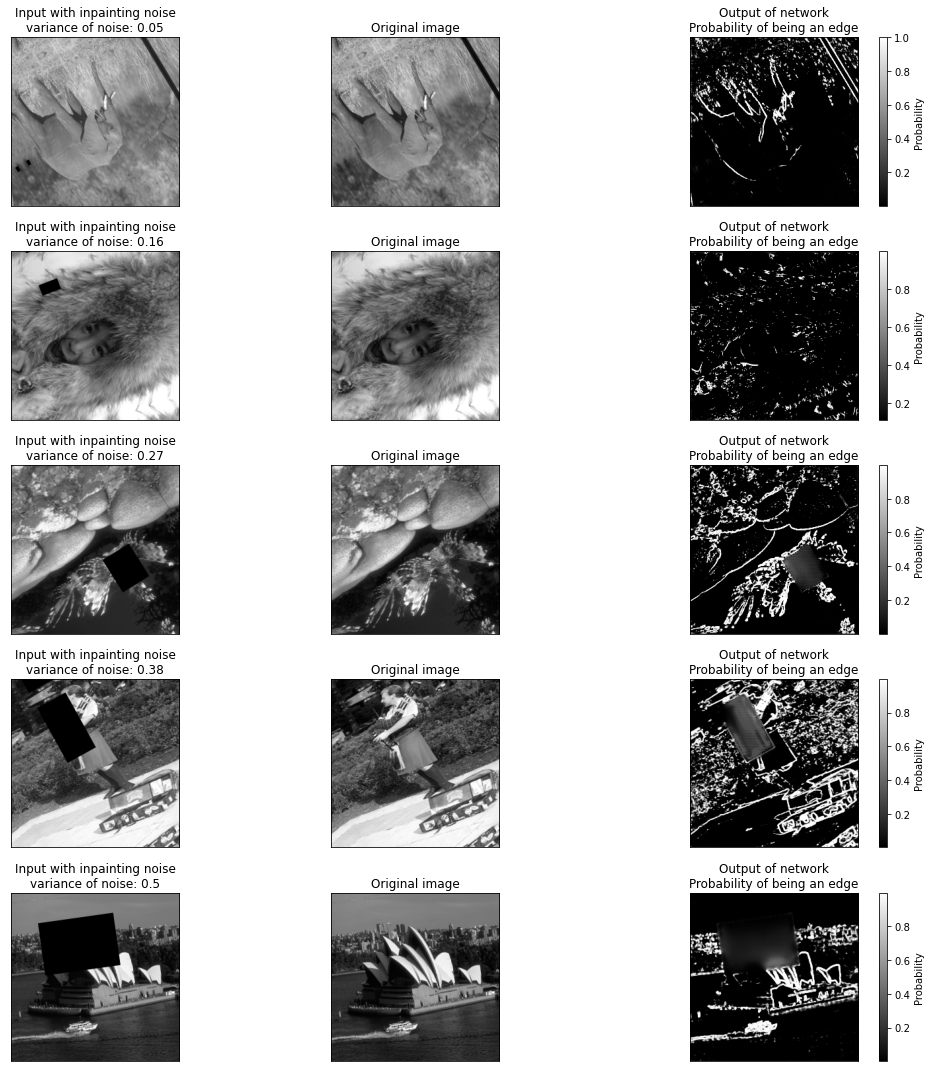

In [2]:
border_classifier = get_model('unet',10,image_size)
available = glob(f'./checkpoints/classifier_{typ}*.index')
trained = [float(i.split('_')[-1][:-6]) for i in available]

fig,axs = plt.subplots(ncols=3,nrows=len(trained),figsize=(15,15))

for i,var in enumerate(np.sort(trained)):
    comparison = np.array(trained) - var
    border_classifier.load_weights(available[np.argmin(np.where(comparison >=0,comparison,1e16))][:-6])
    gen_batch_train,gen_batch_val = get_generators(typ,var,CROP1=CROP,BATCH_SIZE=5)
    xs, ys = next(gen_batch_val.as_numpy_iterator())
    q = border_classifier(xs)
    _ = np.random.choice(len(xs))
    
    axs[i,0].imshow(np.squeeze(xs[_]),cmap="gray")
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,0].set_title(f"Input with {typ} noise\nvariance of noise: {var}")
    axs[i,1].imshow(np.squeeze(ys[_]),cmap="gray")
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,1].set_title("Original image")
    im = axs[i,2].imshow(np.squeeze(q[_]),cmap="gray")
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    axs[i,2].set_title("Output of network\nProbability of being an edge")
    plt.colorbar(im,ax=axs[i,2],label="Probability")
    
plt.tight_layout()
plt.show()

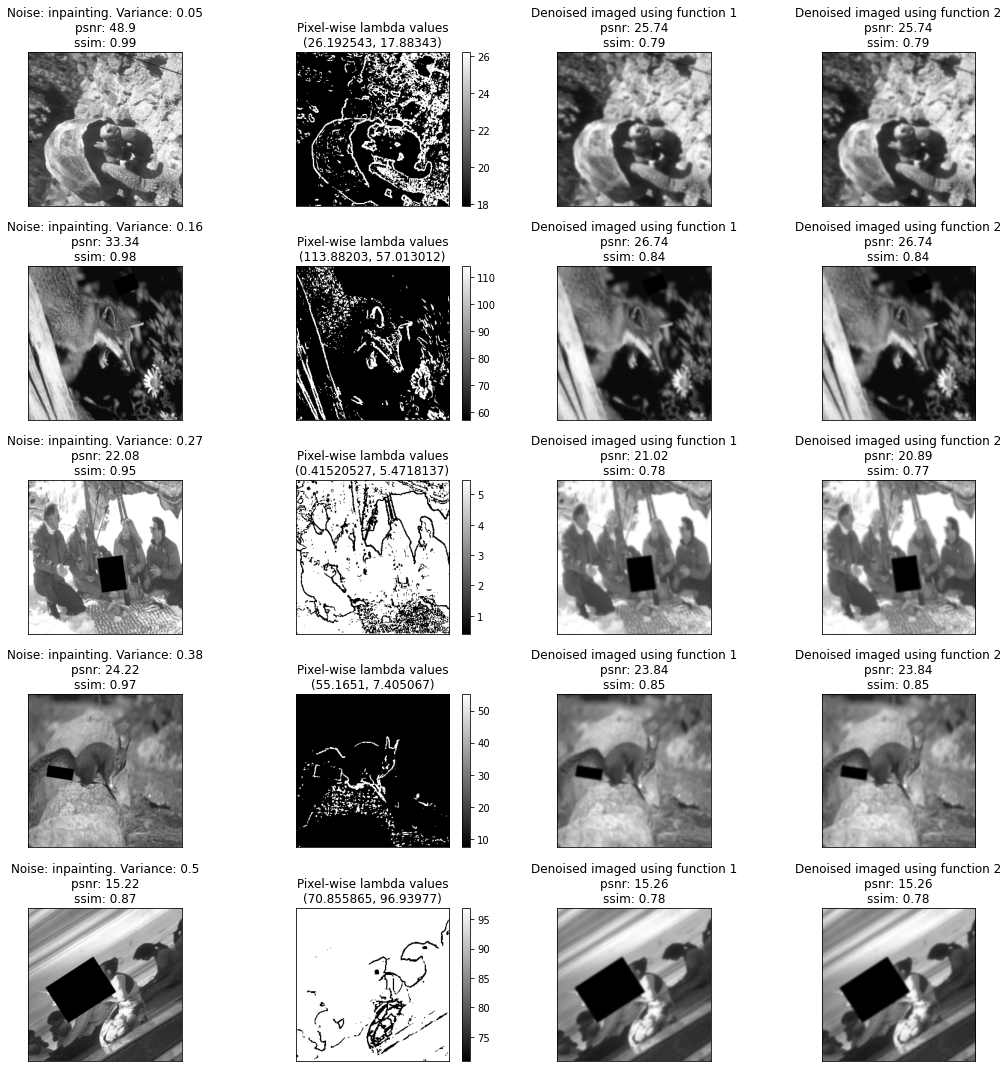

In [3]:
fig,axs = plt.subplots(ncols=4,nrows=len(trained),figsize=(15,15))

for i,var in enumerate(np.sort(trained)):
    gen_batch_train,gen_batch_val = get_generators(typ,var,CROP1=CROP,BATCH_SIZE=5)
    xs, ys = next(gen_batch_val.as_numpy_iterator())
    
    option = 1
    model1 = get_model("border_lambdas",10,image_size,typ=typ,num_classes = 1,option = option,var=var)
    model1.load_weights(f'./checkpoints/border_lambdas_{typ}_{var}_{option}')
    
    option = 2
    model2 = get_model("border_lambdas",10,image_size,typ=typ,num_classes = 1,option = option,var=var)
    model2.load_weights(f'./checkpoints/border_lambdas_{typ}_{var}_{option}')
    
    lam_1 = tf.keras.models.Model(model1.input,model1.get_layer('lambdas_1').output)
    lam_2 = tf.keras.models.Model(model1.input,model1.get_layer('lambdas_2').output)
    coeffs1 = tf.keras.models.Model(model1.input,model1.get_layer('lambda_val').output)
    coeffs2 = tf.keras.models.Model(model2.input,model2.get_layer('lambda_val').output)
    
    p1 = model1(xs)
    p2 = model2(xs)
    l1,l2 = np.ndarray.flatten(lam_1(xs).numpy()),np.ndarray.flatten(lam_2(xs).numpy())
    l1,l2 = np.abs(l1),np.abs(l2)
    c1 = coeffs1(xs)
    c2 = coeffs2(xs)
    _ = np.random.choice(len(xs))
    
    axs[i,0].imshow(xs[_],cmap="gray")
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    psnr = tf.image.psnr(ys[_],xs[_],1)
    ssim = tf.image.ssim(ys[_],xs[_],1)
    axs[i,0].set_title(f"Noise: {typ}. Variance: {var}\npsnr: {int(100*psnr)/100}\nssim: {int(100*ssim)/100}")
    im = axs[i,1].imshow(1/np.sqrt(np.squeeze(c1.numpy()[_])),cmap='gray')
    plt.colorbar(im,ax=axs[i,1])
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,1].set_title(f"Pixel-wise lambda values\n{l1[_],l2[_]}")
    pm = anisodiff_nn(xs[_],lambd=1/np.sqrt(np.squeeze(c1.numpy()[_])),niter = 10,option=1)
    psnr = tf.image.psnr(ys[_],pm,1)
    ssim = tf.image.ssim(ys[_],pm,1)
    axs[i,2].imshow(pm,cmap="gray")
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    axs[i,2].set_title(f"Denoised imaged using function 1\npsnr: {int(100*psnr)/100}\nssim: {int(100*ssim)/100}")
    #axs[i,3].imshow(p2[_],cmap="gray")
    pm = anisodiff_nn(xs[_],lambd=1/np.sqrt(np.squeeze(c2.numpy()[_])),niter = 10,option=2)
    psnr = tf.image.psnr(ys[_],pm,1)
    ssim = tf.image.ssim(ys[_],pm,1)
    axs[i,3].imshow(pm,cmap="gray")
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    axs[i,3].set_title(f"Denoised imaged using function 2\npsnr: {int(100*psnr)/100}\nssim: {int(100*ssim)/100}")
    
plt.tight_layout()
plt.show()

In [4]:
gen_batch_train,gen_batch_val = get_generators(typ,var,CROP1=CROP,BATCH_SIZE=500)
xs, ys = next(gen_batch_val.as_numpy_iterator())
coeffs1 = tf.keras.models.Model(model1.input,model1.get_layer('lambda_val').output)
coeffs2 = tf.keras.models.Model(model2.input,model2.get_layer('lambda_val').output)
c1,c2 = coeffs1(xs),coeffs2(xs)

In [5]:
mean1,std1,mean2,std2 = [],[],[],[]
mean0,std0,mean,std = [],[],[],[]

smean1,sstd1,smean2,sstd2 = [],[],[],[]
smean0,sstd0,smean,sstd = [],[],[],[]

for var in np.sort(trained):
    
    option = 1
    model1 = get_model("border_lambdas",10,image_size,typ=typ,num_classes = 1,option = option,var=var)
    model1.load_weights(f'./checkpoints/border_lambdas_{typ}_{var}_{option}')
    
    option = 2
    model2 = get_model("border_lambdas",10,image_size,typ=typ,num_classes = 1,option = option,var=var)
    model2.load_weights(f'./checkpoints/border_lambdas_{typ}_{var}_{option}')
    
    gen_batch_train,gen_batch_val = get_generators(typ,var,CROP1=CROP,BATCH_SIZE=500)
    xs, ys = next(gen_batch_val.as_numpy_iterator())
    coeffs1 = tf.keras.models.Model(model1.input,model1.get_layer('lambda_val').output)
    coeffs2 = tf.keras.models.Model(model2.input,model2.get_layer('lambda_val').output)
    c1,c2 = coeffs1(xs),coeffs2(xs)

    PSNR1,SSIM1,PSNR2,SSIM2 = [],[],[],[]
    PSNR0,SSIM0,PSNR,SSIM = [],[],[],[]

    for _ in tqdm(range(len(ys))):
        
        psnr = tf.image.psnr(ys[_],xs[_],1)
        ssim = tf.image.ssim(ys[_],xs[_],1)
        
        pm0 = anisodiff(xs[_],lambd=1,niter = 10,option=1)
        psnr0 = tf.image.psnr(ys[_],pm0,1)
        ssim0 = tf.image.ssim(ys[_],pm0,1)
        
        pm1 = anisodiff_nn(xs[_],lambd=1/np.sqrt(np.squeeze(c1.numpy()[_])),niter = 10,option=1)
        psnr1 = tf.image.psnr(ys[_],pm1,1)
        ssim1 = tf.image.ssim(ys[_],pm1,1)

        pm2 = anisodiff_nn(xs[_],lambd=1/np.sqrt(np.squeeze(c2.numpy()[_])),niter = 10,option=2)
        psnr2 = tf.image.psnr(ys[_],pm2,1)
        ssim2 = tf.image.ssim(ys[_],pm2,1)

        PSNR.append(psnr.numpy())
        SSIM.append(ssim.numpy())
        PSNR0.append(psnr0.numpy())
        SSIM0.append(ssim0.numpy())
        
        PSNR1.append(psnr1.numpy())
        SSIM1.append(ssim1.numpy())
        PSNR2.append(psnr2.numpy())
        SSIM2.append(ssim2.numpy())
        
    mean.append(np.mean(PSNR))
    std.append(np.std(PSNR))
    mean0.append(np.mean(PSNR0))
    std0.append(np.std(PSNR0))
    mean1.append(np.mean(PSNR1))
    std1.append(np.std(PSNR1))
    mean2.append(np.mean(PSNR2))
    std2.append(np.std(PSNR2))
    
    smean.append(np.mean(SSIM))
    sstd.append(np.std(SSIM))
    smean0.append(np.mean(SSIM0))
    sstd0.append(np.std(SSIM0))
    smean1.append(np.mean(SSIM1))
    sstd1.append(np.std(SSIM1))
    smean2.append(np.mean(SSIM2))
    sstd2.append(np.std(SSIM2))

100%|█████████████████████████████████████████| 500/500 [00:35<00:00, 14.12it/s]
/home/joel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


100%|█████████████████████████████████████████| 500/500 [00:35<00:00, 14.01it/s]


100%|█████████████████████████████████████████| 500/500 [00:35<00:00, 14.11it/s]


100%|█████████████████████████████████████████| 500/500 [00:35<00:00, 14.08it/s]


100%|█████████████████████████████████████████| 500/500 [00:35<00:00, 13.98it/s]


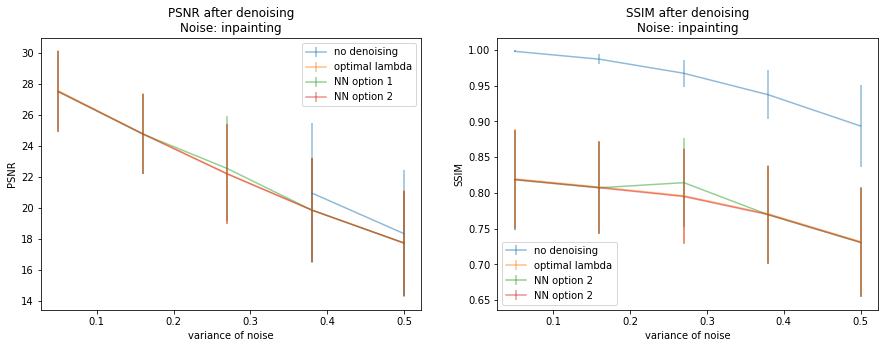

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.errorbar(np.sort(trained),mean,std,alpha=0.5,label='no denoising')
plt.errorbar(np.sort(trained),mean0,std0,alpha=0.5,label='optimal lambda')
plt.errorbar(np.sort(trained),mean1,std1,alpha=0.5,label='NN option 1')
plt.errorbar(np.sort(trained),mean2,std2,alpha=0.5,label='NN option 2')
plt.xlabel('variance of noise')
plt.ylabel('PSNR')
plt.title(f'PSNR after denoising\nNoise: {typ}')
plt.legend()

plt.subplot(122)
plt.errorbar(np.sort(trained),smean,sstd,alpha=0.5,label='no denoising')
plt.errorbar(np.sort(trained),smean0,sstd0,alpha=0.5,label='optimal lambda')
plt.errorbar(np.sort(trained),smean1,sstd1,alpha=0.5,label='NN option 2')
plt.errorbar(np.sort(trained),smean2,sstd2,alpha=0.5,label='NN option 2')
plt.xlabel('variance of noise')
plt.ylabel('SSIM')
plt.title(f'SSIM after denoising\nNoise: {typ}')
plt.legend()

plt.show()